---
title: "Instrumental variable analysis with Bayesian modeling and statsmodels"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Instrumental variable (IV) analysis is one method for causal inference. This approach relies on using an instrumental variable $Z$ to find the true relationship between an explanatory variable $X$ with an outcome $Y$. In my path towards understanding this method and eventually applying it towards Mendelian randomization, I explore some methods and approaches in a series of posts. In this first post, I'm using an implementation of IV analysis with Bayesian modeling and comparing it with [two-stage least squares (2SLS)](https://benslack19.github.io/data%20science/statistics/cross-sectional-survey-designs/#instrumental-variables) using  `statsmodels`. Both the Bayesian approach and the 2SLS method rely on minimizing the influence of confounds between $X$ and $Y$ to uncover the true, causal relationship between them. The key is understanding how confounds lurk in the error terms of respective models and then see how the instrument addresses them.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from scipy.special import expit
from statsmodels.sandbox.regression.gmm import IV2SLS
from utils import draw_causal_graph, standardize

In [2]:
RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
sns.set_context("talk")
sns.set_palette("colorblind")

# Causal graph of example dataset

I will use the example of IV analysis described in Chapter 14 of [Statistical Rethinking by Richard McElreath](https://www.taylorfrancis.com/books/mono/10.1201/9780429029608/statistical-rethinking-richard-mcelreath). This example is an attempt to ask the question, how much does education `E` influence someone's wages `W`? Does more schooling lead to more income? We cannot simply regress `W` on `E` because of variables (confounds) that can influence both. One confound could be work ethic. Someone who works hard is motivated to seek more education and be driven at their job to earn more. How would IV analysis then be used to remove the influence of such a confound? By identifying another variable (the instrument) that would influence only education and not wages. In McElreath's example, the quarter that someone was born (instrumental variable `Q`) can be used deconfound `E` on `W`. Why can this work? Per the book: "... people born earlier in the year tend to get less schooling. This is both because they are biologically older when they start school and because they become eligible to drop out of school earlier." Here is our causal graph, where he variable `U` represents unobserved confounders.


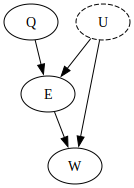

In [3]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "W"), ("E", "W")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

This causal structure can be used to inform data that we'll simulate for this exercise. Note that we're explicitly making the influence of education on wages (`bEW_sim`) equal to 0. This is the estimate we want to recover in all inferential 
statistical models. We'll standardize all variables to facilitate model building and interpretation of results.

In [4]:
N = 500
bEW_sim = 0

U_sim = np.random.normal(size=N)
Q_sim = np.random.randint(1, 5, N)
E_sim = np.random.normal(loc=U_sim + Q_sim, size=N)
W_sim = np.random.normal(loc=U_sim + bEW_sim * E_sim, size=N)
dat_sim = pd.DataFrame.from_dict(
    {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
)

To enhance our understanding, we can visualize the data but being conscious that looking at the data only tells us nothing about causal relationships. The figure on the left is showing a relationship between `Q` and `E` but so does `E` and `W` on the right. Only the left figure is a causal relationship. We set `bEW_sim` to 0 so we know the correlation we're seeing is a result of the confound `U`.

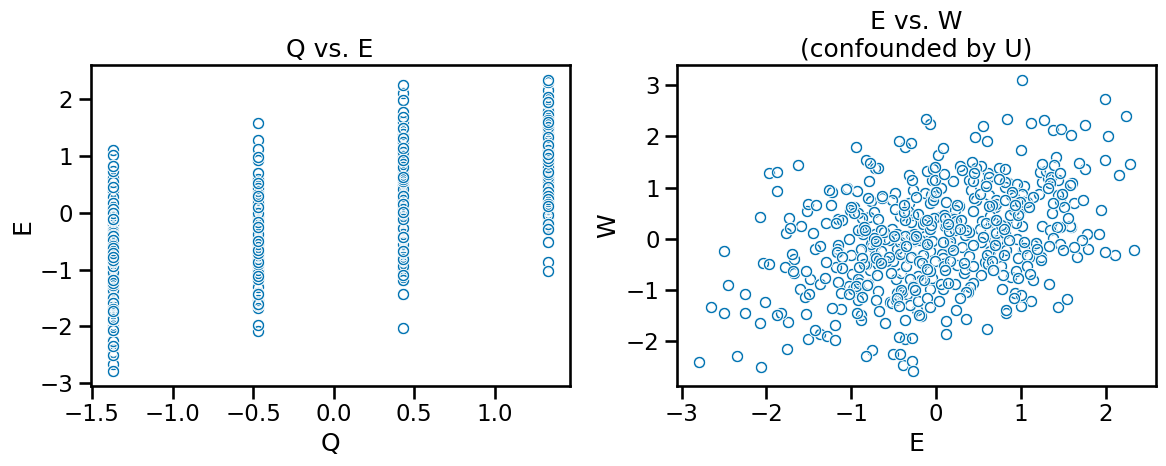

In [5]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=dat_sim, x="Q", y="E", marker=r"$\circ$", ax=ax0)
ax0.set_title("Q vs. E")
sns.scatterplot(data=dat_sim, x="E", y="W", marker=r"$\circ$", ax=ax1)
ax1.set_title("E vs. W\n(confounded by U)")

f.tight_layout()

As the book details, if we create simple linear regression models (since we're pretending `U` is unobserved) we will get incorrect, biased estimates. Including  `Q` will result in bias amplification, making the estimate worse. But with this causal graph structure, IV analysis is applicable for proper estimation of `E` on `W`. We'll start with a Bayesian approach for IV analysis before doing 2SLS.

# Bayesian modeling approach

The variable `U` is a confound that acts as a [fork](https://benslack19.github.io/data%20science/statistics/stats_rethinking_corr_diffDAGs/#fork) creating a correlation between `E` and `W`. The Bayesian approach involves use of a multivariate linear model (e.g. multiple outcome variables) that acknowledges this covariance. By embedding the correlation structure into the model, we can recover a proper coefficient for education on wages $\beta_{EW}$. Here is how we can include the observed variables in one model for the Bayesian approach, as shown on page 458 of Statistical Rethinking.

$$ \left( \begin{array}{c} W_i \\ {E_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{W_i}}  \\ {\mu_{E_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{W_i} = \alpha_W + \beta_{EW} W_i  $$
$$ \mu_{E_i} = \alpha_E + \beta_{QE} E_i  $$
$$ \alpha_W, \alpha_E \sim \text{Normal}(0, 0.2) $$
$$ \beta_{EW}, \beta_{QE} \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{W}^2 & \rho\sigma_{W}\sigma_{E} \\ 
                \rho\sigma_{W}\sigma_{E} & \sigma_{E}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{W} & 0 \\ 0 & \sigma_{E} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$


We can implement these equations and run the Bayesian statistical model. This is the book's description of model 14.6 and I am using the [pymc translation](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb) of R code 14.26.

In [6]:
with pm.Model() as m14_6:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values
    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    WE_obs = pm.Data("WE_obs", dat_sim[["W", "E"]].values, mutable=True)
    WE = pm.MvNormal("WE", mu=pt.stack([muW, muE]).T, chol=chol, observed=WE_obs)

    trace_14_6 = pm.sample(1000, random_seed=RANDOM_SEED)
    trace_14_6.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)

df_trace_14_6_summary = az.summary(
    trace_14_6, var_names=["aW", "aE", "bEW", "bQE", "Rho", "Sigma"], round_to=2
)
df_trace_14_6_summary

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,-0.00,0.04,-0.08,0.08,0.0,0.0,4150.99,3688.87,1.0
aE,-0.00,0.03,-0.06,0.06,0.0,0.0,3692.50,2853.40,1.0
bEW,0.05,0.06,-0.08,0.16,0.0,0.0,2131.69,2631.97,1.0
bQE,0.68,0.03,0.62,0.74,0.0,0.0,2963.05,3214.42,1.0
"Rho[0, 0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,NaN
"Rho[0, 1]",0.46,0.05,0.36,0.56,0.0,0.0,2179.65,2729.02,1.0
"Rho[1, 0]",0.46,0.05,0.36,0.56,0.0,0.0,2179.65,2729.02,1.0
"Rho[1, 1]",1.00,0.00,1.00,1.00,0.0,0.0,3641.00,3807.84,1.0
Sigma[0],0.99,0.04,0.92,1.06,0.0,0.0,2727.13,2943.37,1.0
Sigma[1],0.73,0.02,0.69,0.78,0.0,0.0,4500.07,3156.00,1.0


The influence of education on wages in our statistical model `bEW` captures 0 (ranges from -0.08 to 0.16), making it consistent with what we had used for `bEW_sim` to generate our data. This is because we were able to account for the correlation between `E` and `W`. As we can see the off-diagonal terms for `Rho` is positive.

Excellent! We've done the first objective of this post. Now let's see how we would do it with two-stage least squares.

# Two-stage least squares approach

As the name implies, here we have two models using ordinary least squares.

In the first stage, we use our instrument `Q` as our predictor variable and `E` will be the outcome. We can completely ignore `W` here. But we know from our generated data that `U` is influencing `E`. If we were to acknowledge `U`, then the linear equation for `E` would look like this.

$ E = \alpha + \beta_{QE}Q + \beta_{UE}U$

But since we're pretending that we don't know about `U` in our inferential models, the influence of `U` would be noise which I denote as $\epsilon$ here.

$ E = \alpha + \beta_{QE}Q + \epsilon$

This is our "first stage" equation. By making a  the fitted model of this first stage equation, we run `Q` back through the model, ignoring noise, and get *predicted* values of `E` which we'll call `E_hat`. The values of `E_hat` are now free from the influence of `U`.

$ \hat{E} = \alpha + \beta_{QE}Q$

Frmo a causal perspective, this results in cutting the backdoor from `W` to `E`. In the second-stage model, we can then use `E_hat` as the predictor variable for `W`. We can then see we get a proper estimate for the coefficient.

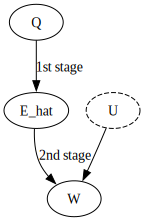

In [7]:
draw_causal_graph(
    edge_list=[("Q", "E_hat"), ("U", "W"), ("E_hat", "W")],
    node_props={"U": {"style": "dashed"}},
    edge_props={
        ("Q", "E_hat"): {"label": "1st stage"},
        ("E_hat", "W"): {"label": "2nd stage"},
    },
    graph_direction="TD",
)

Let's do these steps manually using OLS before trying with the statsmodels `IV2SLS` function.
## statsmodels `OLS`

In [8]:
# First stage: Regress education on Q
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim["Q"])).fit()

# Predicted education added to df
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim["Q"]))
dat_sim.head()

,W,E,Q,E_hat
0,1.147366,1.442103,0.428599,0.292607
1,1.153508,0.386141,-1.372236,-0.936835
2,0.948497,0.413627,-0.471819,-0.322114
3,-0.137755,0.193661,-0.471819,-0.322114
4,-1.653446,-2.076577,-0.471819,-0.322114


In [9]:
# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(dat_sim["W"], sm.add_constant(dat_sim["E_hat"])).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5562
Date:                Tue, 11 Jun 2024   Prob (F-statistic):              0.456
Time:                        12:20:05   Log-Likelihood:                -709.19
No. Observations:                 500   AIC:                             1422.
Df Residuals:                     498   BIC:                             1431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17      0.045    6.2e-16      1.000      -0.088       0.088
E_hat          0.0489      0.066      0.746      0.456      -0.080       0.178
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.885   Jarque-Bera (JB):                0.357
Skew:                           0.014   Prob(JB):                        0.836
Kurtosis:                       2.872   Cond. No.                         1.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While the question of interest is not identifying the $\beta_{QE}$ coefficient, we can get this value.

In [10]:
first_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      E   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     434.7
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           7.20e-70
Time:                        12:20:05   Log-Likelihood:                -552.59
No. Observations:                 500   AIC:                             1109.
Df Residuals:                     498   BIC:                             1118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.665e-16      0.033  -5.09e-15      1.000      -0.064       0.064
Q              0.6827      0.033     20.850      0.000       0.618       0.747
==============================================================================
Omnibus:                        0.118   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.036
Skew:                          -0.007   Prob(JB):                        0.982
Kurtosis:                       3.039   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's implement this with statsmodels `IV2SLS`. The coding is a lot simpler but it only provides the values for the second stage.

## statsmodels `IV2SLS`

In [11]:
# Add a constant to the model (intercept)
df_iv2sls = dat_sim.copy()

fit_iv2sls = IV2SLS(
    endog=df_iv2sls["W"], exog=df_iv2sls["E"], instrument=df_iv2sls["Q"]
).fit()
fit_iv2sls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      W   R-squared:                       0.035
Model:                         IV2SLS   Adj. R-squared:                  0.033
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Tue, 11 Jun 2024                                         
Time:                        12:20:05                                         
No. Observations:                 500                                         
Df Residuals:                     499                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
E              0.0489      0.064      0.760      0.448      -0.078       0.175
==============================================================================
Omnibus:                        0.308   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.857   Jarque-Bera (JB):                0.424
Skew:                           0.013   Prob(JB):                        0.809
Kurtosis:                       2.860   Cond. No.                         1.00
==============================================================================
"""

# Comparison of estimates between approaches

Let's plot the point estimates and the 95% credible/confidence intervals.

In [12]:
# bayesian values
df_bayesian = (
    df_trace_14_6_summary.loc[["bQE", "bEW"], ["mean", "hdi_3%", "hdi_97%"]]
    .reset_index(names="coefficient")
    .rename(columns=dict(zip(["hdi_3%", "hdi_97%"], ["lower", "upper"])))
    .assign(approach="Bayesian")
)

# OLS values
df_ols = pd.concat(
    [
        pd.concat([first_stage.params, first_stage.conf_int()], axis=1),
        pd.concat([second_stage.params, second_stage.conf_int()], axis=1),
    ]
)
df_ols.columns = ["mean", "lower", "upper"]
df_ols = (
    df_ols.drop("const")
    .rename(index={"Q": "bQE", "E_hat": "bEW"})
    .reset_index(names="coefficient")
    .assign(approach="OLS")
)

# IV2SLS values
df_iv2sls = pd.concat(
    [
        pd.concat([fit_iv2sls.params, fit_iv2sls.conf_int()], axis=1),
    ]
)
df_iv2sls.columns = ["mean", "lower", "upper"]

df_iv2sls = (
    df_iv2sls.rename(index={"E": "bEW"})
    .reset_index(names="coefficient")
    .assign(approach="IV2SLS")
)

df_estimates = pd.concat([df_bayesian, df_ols, df_iv2sls], ignore_index=True)
df_estimates

,coefficient,mean,lower,upper,approach
0,bQE,0.680000,0.620000,0.740000,Bayesian
1,bEW,0.050000,-0.080000,0.160000,Bayesian
2,bQE,0.682707,0.618376,0.747039,OLS
3,bEW,0.048923,-0.079966,0.177811,OLS
4,bEW,0.048923,-0.077613,0.175458,IV2SLS


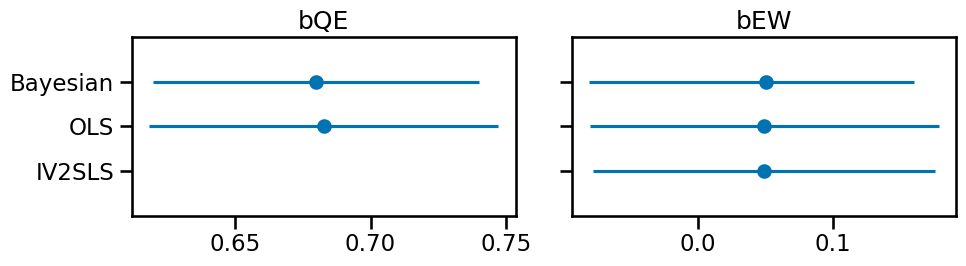

In [13]:
def plot_coef_estimates(ax, coefficient):
    df = df_estimates.query("coefficient==@coefficient")
    x_mean_vals = df["mean"].tolist() + [None] if len(df) == 2 else df["mean"].tolist()
    x_min_vals = df["lower"].tolist() + [None] if len(df) == 2 else df["lower"].tolist()
    x_max_vals = df["upper"].tolist() + [None] if len(df) == 2 else df["upper"].tolist()
    ax.scatter(
        x=x_mean_vals,
        y=range(3),
    )
    ax.hlines(
        xmin=x_min_vals,
        xmax=x_max_vals,
        y=range(3),
    )
    ax.set_ylim([-1, 3])
    ax.set_yticks(range(3))
    ax.set_yticklabels(["Bayesian", "OLS", "IV2SLS"])
    ax.invert_yaxis()
    ax.set_title(coefficient)
    return ax

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plot_coef_estimates(ax0, "bQE")
plot_coef_estimates(ax1, "bEW")
f.tight_layout()

The Bayesian approach shows a slightly negative value for `bEW` but the credible interval spans 0 like the `statsmodels` approaches.

In this post, I demonstrate how to run instrumental variable analysis using a Bayesian approach with `pymc` and the two-stage least squares approach with `statsmodels`. Have a great day!

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jun 11 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

scipy      : 1.13.0
pymc       : 5.15.0
pandas     : 2.2.2
matplotlib : 3.8.4
numpy      : 1.26.4
arviz      : 0.18.0
seaborn    : 0.13.2
statsmodels: 0.14.2
pytensor   : 2.20.0

Watermark: 2.4.3

